In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
df_app = pd.read_parquet('../data/processed/application_train_clean.parquet')
df_bureau = pd.read_parquet('../data/processed/bureau_agg.parquet')


In [46]:
df_app = df_app.copy()
df_bureau = df_bureau.copy()

df_app.columns = df_app.columns.str.lower()
df_bureau.columns = df_bureau.columns.str.lower()

In [47]:
df = df_app.merge(df_bureau, on="sk_id_curr", how="left")

In [48]:
#DAYS_EMPLOYED-> handle PLACEHOLDER

In [49]:
EMPLOYED_PLACEHOLDER = 365243

In [50]:
df["is_currently_employed"] = (df["days_employed"] < EMPLOYED_PLACEHOLDER).astype(int)

In [51]:
df["days_employed_clean"] = df["days_employed"].replace(
    EMPLOYED_PLACEHOLDER, np.nan
)

In [52]:
df["employed_years"] = -df["days_employed_clean"] / 365
df["employed_years"]

0          1.745205
1          3.254795
2          0.616438
3          8.326027
4          8.323288
            ...    
307506     0.646575
307507          NaN
307508    21.701370
307509    13.112329
307510     3.457534
Name: employed_years, Length: 307511, dtype: float64

In [53]:
num_cols = [
    # monetary
    "amt_income_total",
    "amt_credit",
    "amt_annuity",
    "amt_goods_price",

    # time / lifecycle
    "days_birth",
    "days_employed_clean",
    "days_registration",

    # external risk scores
    "ext_source_1",
    "ext_source_2",
    "ext_source_3",

    # region / context
    "region_population_relative",

    # housing (representative only)
    "apartments_avg",
    "livingarea_avg",
    "nonlivingarea_avg",
    "years_build_avg",
    "years_beginexpluatation_avg",
    "elevators_avg",
    "floorsmax_avg",
]

In [54]:
skewness = (
    df[num_cols]
    .skew()
    .sort_values(ascending=False)
)

skewness

nonlivingarea_avg               6.559012
livingarea_avg                  2.854736
apartments_avg                  2.641836
elevators_avg                   2.439429
amt_annuity                     1.579777
region_population_relative      1.488009
amt_income_total                1.355259
amt_goods_price                 1.349000
floorsmax_avg                   1.226454
amt_credit                      1.025188
ext_source_1                   -0.068755
days_birth                     -0.115673
ext_source_3                   -0.409390
days_registration              -0.590872
ext_source_2                   -0.793576
years_build_avg                -0.962485
days_employed_clean            -1.968316
years_beginexpluatation_avg   -15.515264
dtype: float64

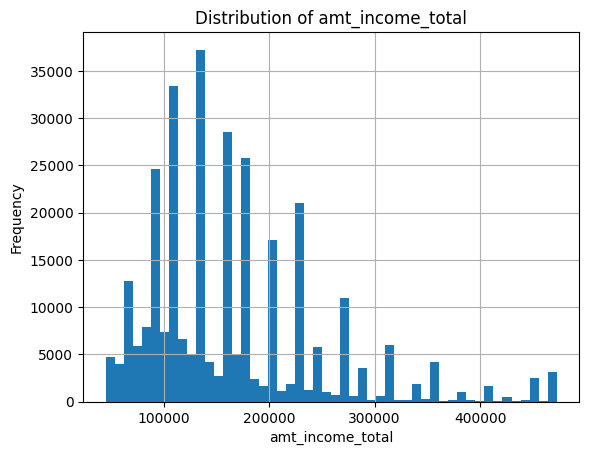

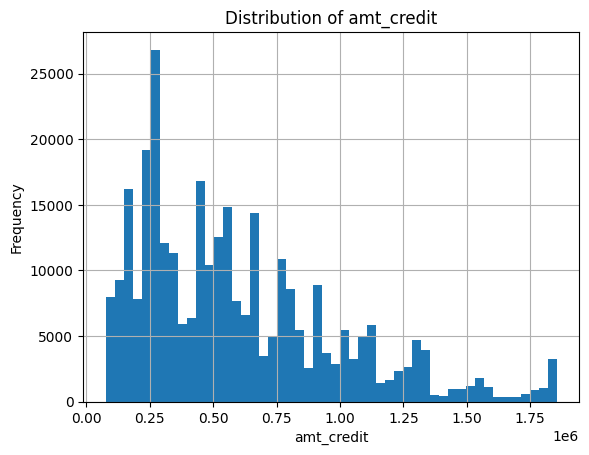

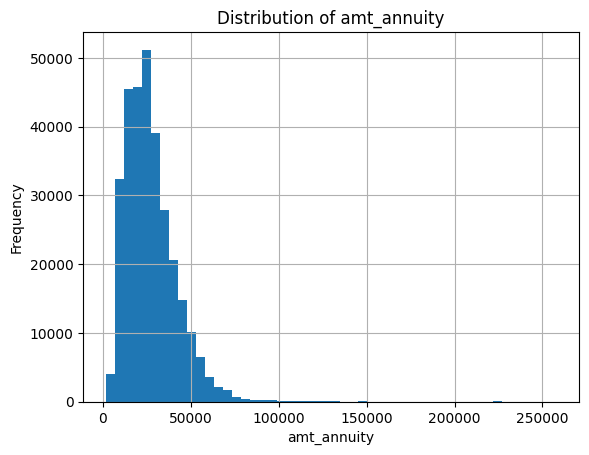

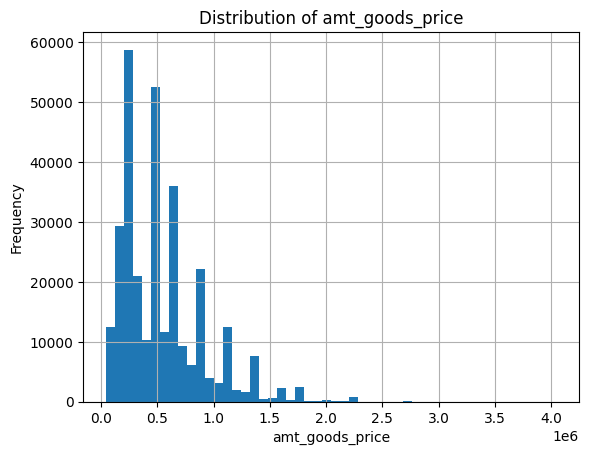

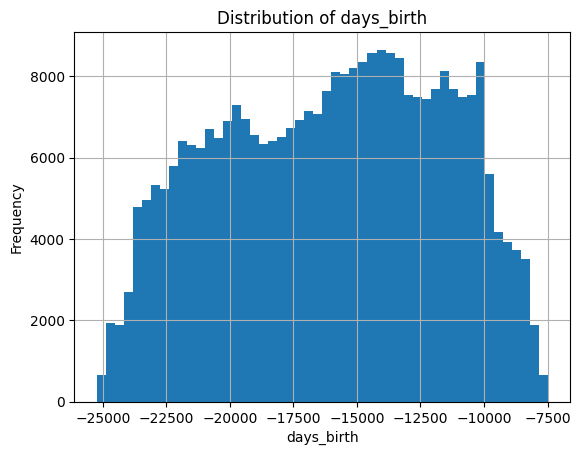

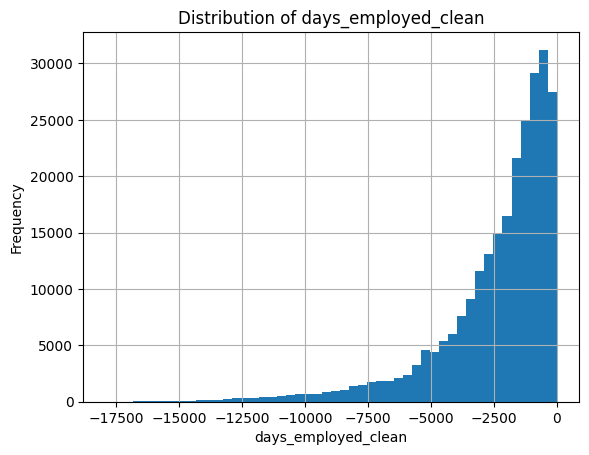

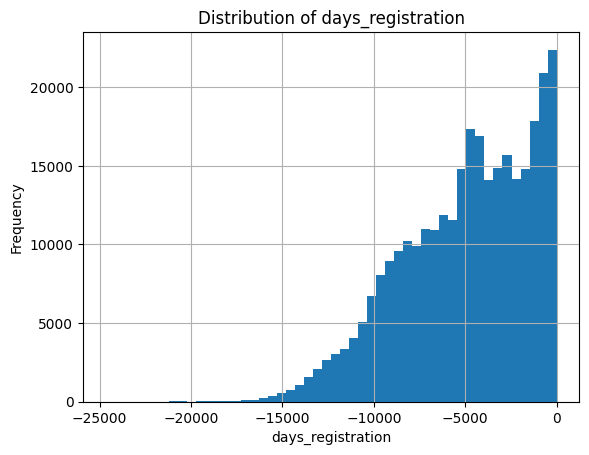

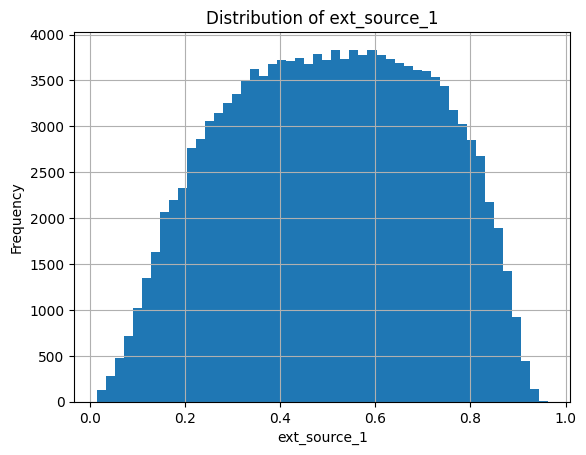

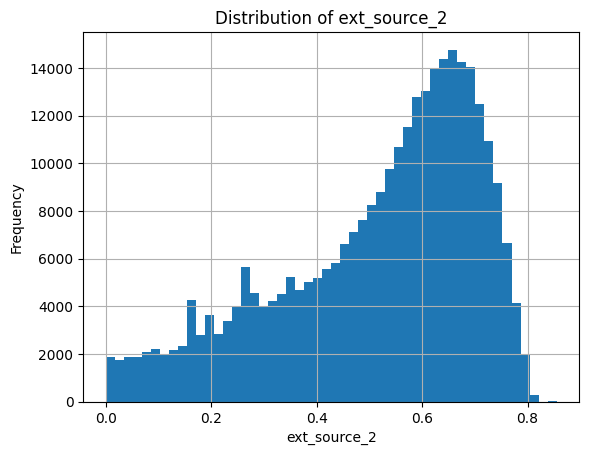

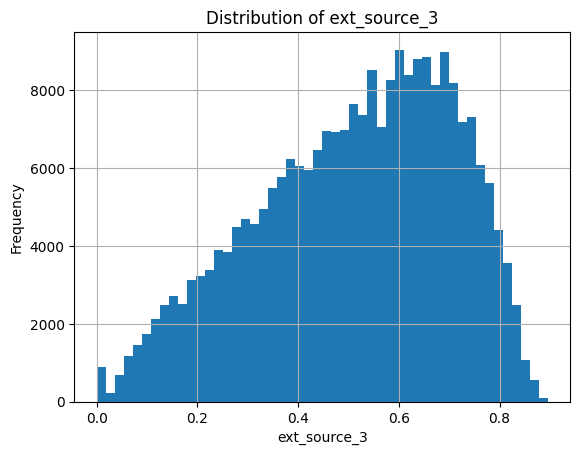

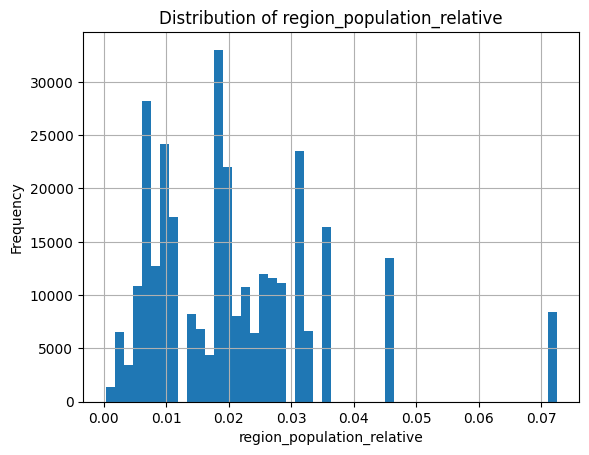

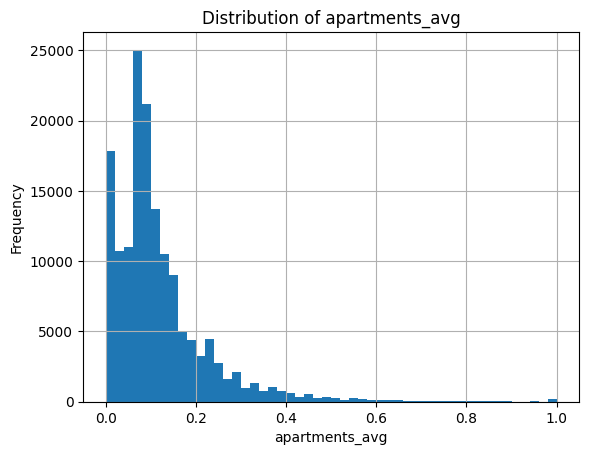

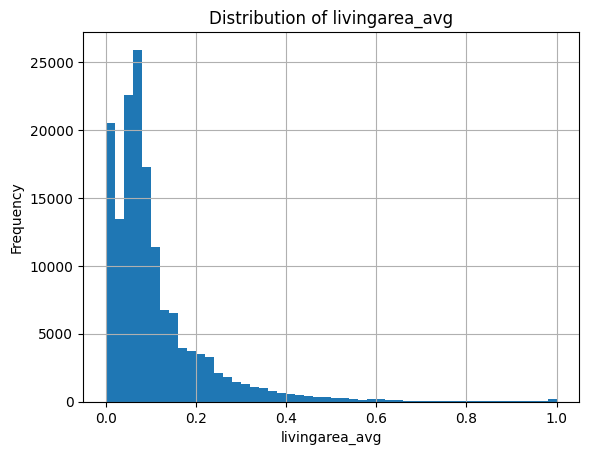

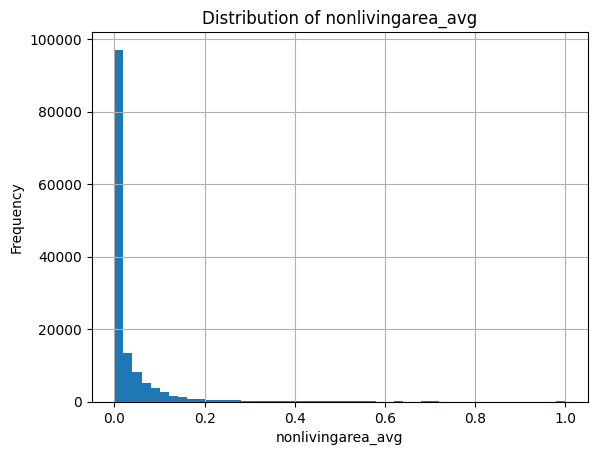

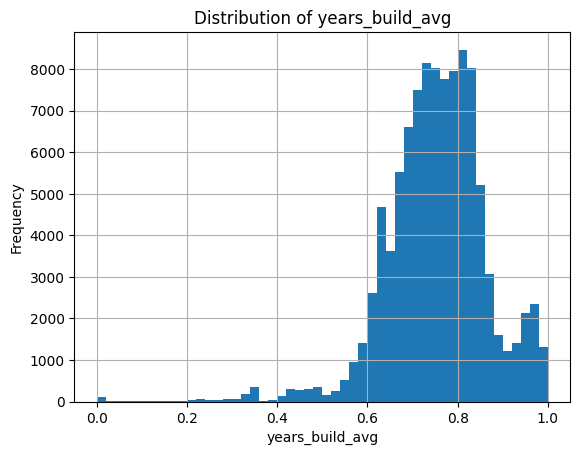

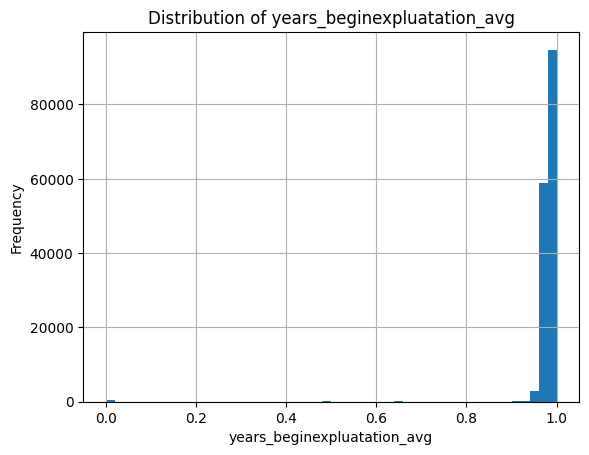

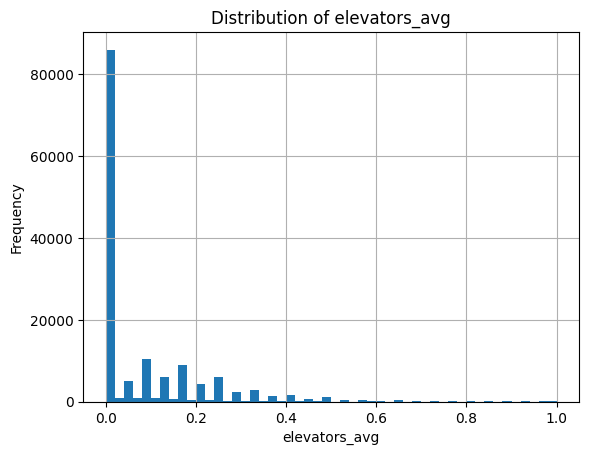

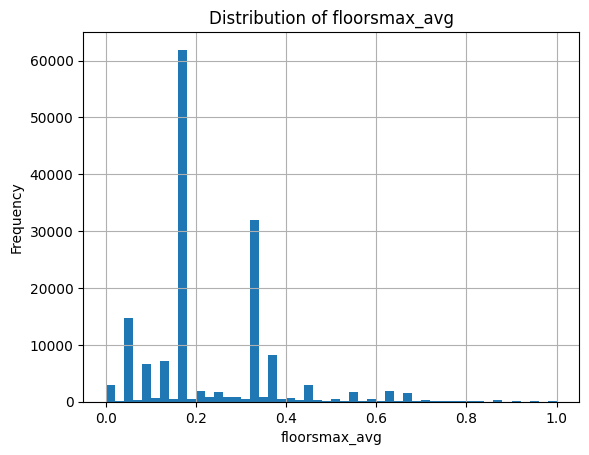

In [55]:
for col in num_cols:
    plt.figure()
    df[col].hist(bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

skew>2 ->log
1 < skew ≤ 2 ->log??
skew < -1 explain

The skewness analysis reveals that most monetary and housing-related variables
exhibit right-skewed distributions, which is common in credit risk data.

Variables related to property size and facilities show particularly strong
right skewness, indicating the presence of a small number of high-value outliers.
Logarithmic transformations are therefore considered for these features.

In contrast, external risk scores and age-related variables are approximately
symmetric and are kept in their original scale to preserve interpretability.

In [56]:
df["debt_to_income"] = (
    df["amt_annuity"] / df["amt_income_total"]
)

df.loc[df["amt_income_total"] <= 0, "debt_to_income"] = np.nan

In [57]:
df["debt_to_income"].describe()

count    307499.000000
mean          0.180851
std           0.093345
min           0.008700
25%           0.115214
50%           0.162860
75%           0.228850
max           1.570600
Name: debt_to_income, dtype: float64

✅ Final Feature Set Structure (Application-level)

Grain: one row per loan application (SK_ID_CURR)

In [58]:
# Numerical Features
#1.1 Affordability & Loan Characteristics

In [59]:
features_numeric_affordability = [
    "amt_income_total",
    "amt_credit",
    "amt_annuity",
    "debt_to_income",
]

In [60]:
#1.2 Employment Stability

In [61]:
features_numeric_employment = [
    "is_currently_employed",
    "days_employed_clean",
]

In [62]:
#1.3 External Risk Scores

In [63]:
features_numeric_external = [
    "ext_source_1",
    "ext_source_2",
    "ext_source_3",
]

In [64]:
#1.4 Credit Bureau (Aggregated Behavior)

In [65]:
features_numeric_bureau = [
    "bureau_sum_debt",      
    "bureau_sum_overdue",    
    "bureau_active_cnt",     
]

In [66]:
# All Numerical Features

In [67]:
features_numeric = (
    features_numeric_affordability
    + features_numeric_employment
    + features_numeric_external
    + features_numeric_bureau
)

In [68]:
# Categorical Features

In [69]:
features_categorical = [
    "name_contract_type",
    "name_income_type",
    "name_education_type",
    "name_family_status",
    "name_housing_type",
]

In [70]:
corr = df[features_numeric].corr()
corr

,amt_income_total,amt_credit,amt_annuity,debt_to_income,is_currently_employed,days_employed_clean,ext_source_1,ext_source_2,ext_source_3,bureau_sum_debt,bureau_sum_overdue,bureau_active_cnt
amt_income_total,1.000000,0.406740,0.483958,-0.377501,0.170277,-0.039061,0.093371,0.168954,-0.078737,0.259988,-0.001098,0.154718
amt_credit,0.406740,1.000000,0.768153,0.392312,0.065885,-0.092777,0.169647,0.131169,0.043072,0.096037,-0.003994,0.039534
amt_annuity,0.483958,0.768153,1.000000,0.504163,0.103608,-0.053604,0.119398,0.125804,0.030752,0.090471,-0.001897,-0.005180
debt_to_income,-0.377501,0.392312,0.504163,1.000000,-0.077783,-0.024990,0.053949,-0.032822,0.103539,-0.108506,0.000596,-0.135287
is_currently_employed,0.170277,0.065885,0.103608,-0.077783,1.000000,NaN,-0.294291,0.019508,-0.115263,0.089884,0.005040,0.042349
days_employed_clean,-0.039061,-0.092777,-0.053604,-0.024990,NaN,1.000000,-0.252712,-0.093444,-0.129722,-0.030260,0.003667,-0.082202
ext_source_1,0.093371,0.169647,0.119398,0.053949,-0.294291,-0.252712,1.000000,0.213982,0.186846,0.013136,-0.002614,0.027432
ext_source_2,0.168954,0.131169,0.125804,-0.032822,0.019508,-0.093444,0.213982,1.000000,0.109167,0.051332,-0.001633,-0.002598
ext_source_3,-0.078737,0.043072,0.030752,0.103539,-0.115263,-0.129722,0.186846,0.109167,1.000000,-0.112901,-0.025386,-0.390591
bureau_sum_debt,0.259988,0.096037,0.090471,-0.108506,0.089884,-0.030260,0.013136,0.051332,-0.112901,1.000000,0.010765,0.265858


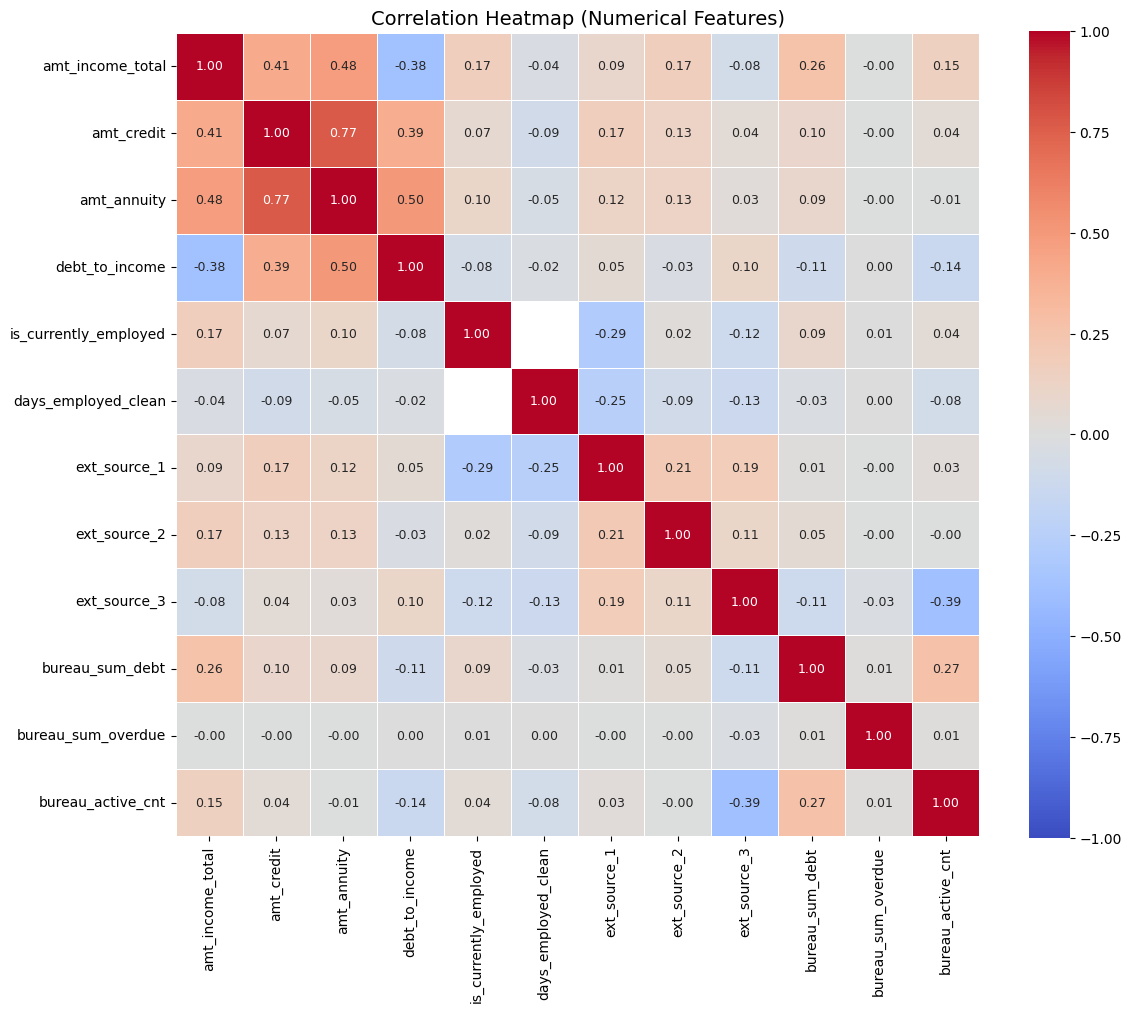

In [71]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    annot=True,          
    fmt=".2f",           
    annot_kws={"size": 9}
)

plt.title("Correlation Heatmap (Numerical Features)", fontsize=14)
plt.tight_layout()
plt.show()

In [72]:
from scipy.stats import chi2_contingency

ct = pd.crosstab(df["name_income_type"], df["target"])
chi2, p, dof, expected = chi2_contingency(ct)

chi2, p

(np.float64(1253.4708080924986), np.float64(1.9281456056861126e-266))

In [73]:
n = ct.to_numpy().sum()
phi2 = chi2 / n
r, k = ct.shape
cramers_v = np.sqrt(phi2 / min(k - 1, r - 1))

cramers_v

np.float64(0.06384498427091885)

In [74]:
# feature transformation

In [75]:
for col in ["amt_income_total", "amt_credit", "amt_annuity"]:
    df[f"{col}_log"] = np.log1p(df[col])

In [76]:
df["years_employed"] = df["days_employed_clean"].abs() / 365

In [77]:
df["bureau_sum_debt_pos"] = df["bureau_sum_debt"].clip(lower=0)
df["bureau_sum_debt_log"] = np.log1p(df["bureau_sum_debt_pos"])

In [78]:
features_numeric_transformed = [
    # affordability
    "amt_income_total_log",
    "amt_credit_log",
    "amt_annuity_log",
    "debt_to_income",

    # employment
    "is_currently_employed",
    "years_employed",

    # external risk
    "ext_source_1",
    "ext_source_2",
    "ext_source_3",

    # bureau
    "bureau_sum_debt_log",
    "bureau_active_cnt",
    "bureau_sum_overdue",
]

In [81]:
missing_numeric_final = (
    df[features_numeric_transformed]
    .isna()
    .mean()
    .sort_values(ascending=False)
)

missing_numeric_final

ext_source_1             0.563811
ext_source_3             0.198253
years_employed           0.180072
bureau_sum_debt_log      0.143149
bureau_active_cnt        0.143149
bureau_sum_overdue       0.143149
ext_source_2             0.002146
amt_annuity_log          0.000039
debt_to_income           0.000039
amt_income_total_log     0.000000
amt_credit_log           0.000000
is_currently_employed    0.000000
dtype: float64

In [ ]:
df[features_categorical].nunique()

name_contract_type     2
name_income_type       8
name_education_type    5
name_family_status     6
name_housing_type      6
dtype: int64

In [ ]:
#export

In [ ]:
TARGET_COL = "target"

FEATURES_ALL = (
    features_numeric_transformed
    + features_categorical
)

In [ ]:
from pathlib import Path

OUTPUT_DIR = Path("../data/processed")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_PATH = OUTPUT_DIR / "application_train_features.parquet"

cols_to_save = [TARGET_COL] + FEATURES_ALL

df[cols_to_save].to_parquet(OUTPUT_PATH, index=False)

OUTPUT_PATH

PosixPath('../data/processed/application_train_features.parquet')